In [2]:
# %% [markdown]
"""
# Analysis of Parallel ACO Experiment Results

This notebook reads the aggregated CSV reports from our ParallelExperiment runs and produces line plots to analyze how the solution quality (best fitness) and runtime change when varying:
1. The number of ants (with fixed batch size)
2. The batch size (with fixed number of ants)

We also include a basic trade-off analysis plot for each experiment.
"""

# %% Import Libraries
import pandas as pd
import matplotlib.pyplot as plt


## Load Aggregated Results

We load the two aggregated CSV files:
- One for varying number of ants ("experiment_varying_ants_summary.csv")
- One for varying batch size ("experiment_varying_batch_size_summary.csv")


In [3]:

# %% Load data
INSTANCES = [
    {"name": "C101_co_100", "summaries": [], "benchmark": 849.26},
    {"name": "R101_co_100", "summaries": [], "benchmark": 776.9},
    {"name": "RC101_co_100", "summaries": [], "benchmark": 1029.2}
]
for i in INSTANCES:
    ants_summary = pd.read_csv(f"experiment/{i['name']}_test1_summary.csv")
    batch_summary = pd.read_csv(f"experiment/{i['name']}_test2_summary.csv")
    i['summaries'] = (ants_summary, batch_summary)

## Experiment 1: Varying Number of Ants

### 1.3 Trade-Off Analysis (Ants Experiment)
Here we plot both the solution quality and runtime on the same plot to help visualize the trade-off.

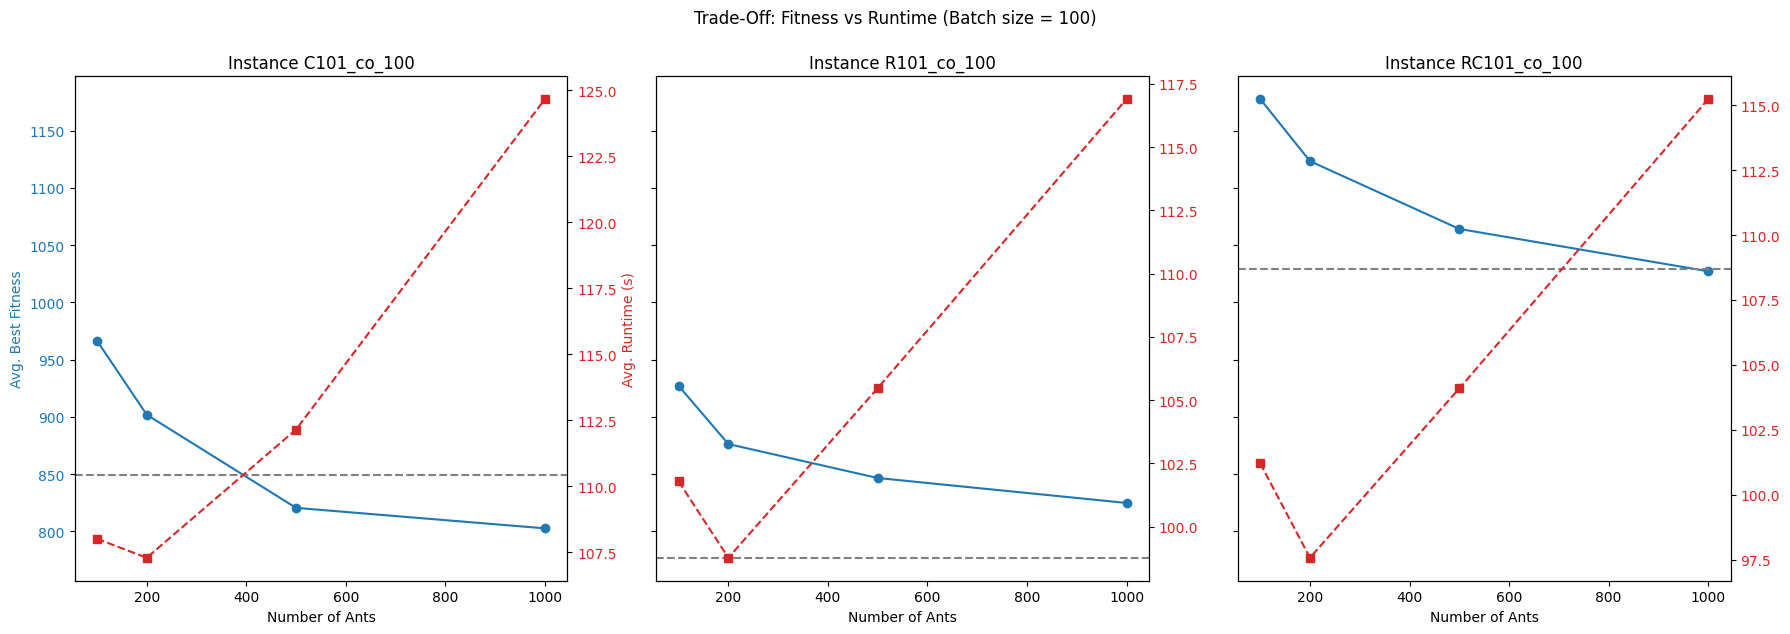

In [4]:
# %% Trade-Off Plot for Number of Ants Experiment
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, instance in enumerate(INSTANCES):
    name = instance['name']
    ants_summary, _ = instance['summaries']
    benchmark = instance['benchmark']
    ax1 = axs[idx]
    color = 'tab:blue'
    ax1.set_xlabel('Number of Ants')
    if idx == 0:
        ax1.set_ylabel('Avg. Best Fitness', color=color)
    ax1.plot(ants_summary['num_ants'], ants_summary['avg_best_fitness'], marker='o', linestyle='-', color=color, label='Avg. Best Fitness')
    ax1.axhline(y=benchmark, color='gray', linestyle='--', label='Benchmark')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    if idx == 0:
        ax2.set_ylabel('Avg. Runtime (s)', color=color)  # we already handled the x-label with ax1
    ax2.plot(ants_summary['num_ants'], ants_summary['avg_runtime'], marker='s', linestyle='--', color=color, label='Avg. Runtime (s)')
    ax2.tick_params(axis='y', labelcolor=color)

    ax1.set_title(f'Instance {name}')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.suptitle('Trade-Off: Fitness vs Runtime (Batch size = 100)', y=1.05)
plt.show()

In [5]:
# Print the drop in percentage of avg best fitness of 1000-ant vs 200-ant
best_fitness_1000, runtime_1000 = ants_summary[ants_summary['num_ants'] == 1000][['avg_best_fitness', 'avg_runtime']].values[0]
best_fitness_200, runtime_200 = ants_summary[ants_summary['num_ants'] == 100][['avg_best_fitness', 'avg_runtime']].values[0]
fitness_drop_percentage = ((best_fitness_1000 - best_fitness_200) / best_fitness_1000) * 100
print(f"Drop in Avg. Best Fitness: {fitness_drop_percentage:.2f}%")
runtime_increase_percentage = ((runtime_1000 - runtime_200) / runtime_1000) * 100
print(f"Increase in Avg. Runtime: {runtime_increase_percentage:.2f}%")
# Increase in num ants
print(f"Increase in num ants: {1000/100:.2f}x")

Drop in Avg. Best Fitness: -14.65%
Increase in Avg. Runtime: 12.16%
Increase in num ants: 10.00x


## Experiment 2: Varying Batch Size

### 2.3 Trade-Off Analysis (Batch Size Experiment)
A combined plot of solution quality and runtime versus batch size.

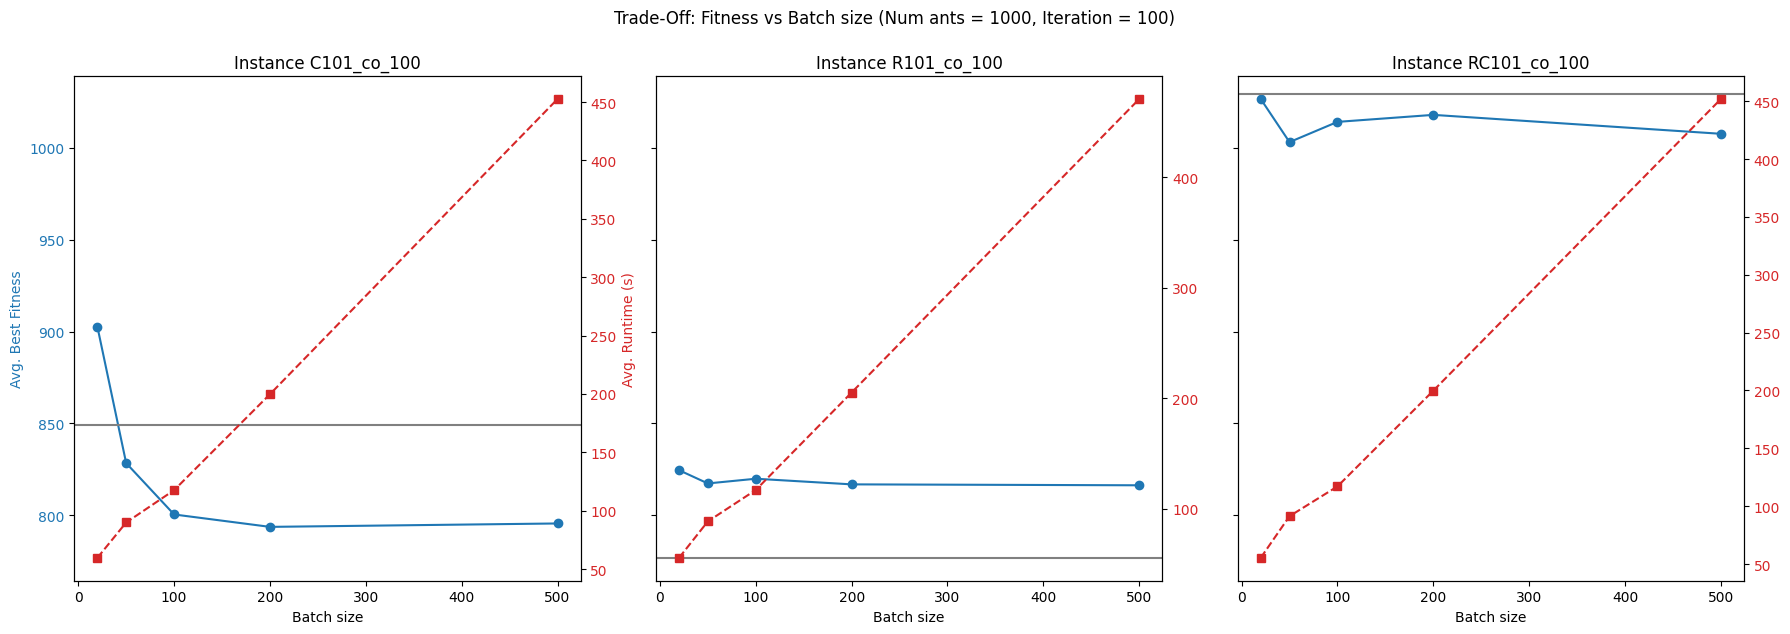

In [6]:
# %% Trade-Off Plot for Number of Ants Experiment
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, instance in enumerate(INSTANCES):
    name = instance['name']
    _, batch_summary = instance['summaries']
    benchmark = instance['benchmark']
    ax1 = axs[idx]
    color = 'tab:blue'
    ax1.set_xlabel('Batch size')
    if idx == 0:
        ax1.set_ylabel('Avg. Best Fitness', color=color)
    ax1.plot(batch_summary['batch_size'], batch_summary['avg_best_fitness'], marker='o', linestyle='-', color=color, label='Avg. Best Fitness')
    ax1.axhline(y=benchmark, color='gray', label='Benchmark')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    if idx == 0:
        ax2.set_ylabel('Avg. Runtime (s)', color=color)  # we already handled the x-label with ax1
    ax2.plot(batch_summary['batch_size'], batch_summary['avg_runtime'], marker='s', linestyle='--', color=color, label='Avg. Runtime (s)')
    ax2.tick_params(axis='y', labelcolor=color)

    ax1.set_title(f'Instance {name}')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.suptitle('Trade-Off: Fitness vs Batch size (Num ants = 1000, Iteration = 100)', y=1.05)
plt.show()

In [ ]:
# Speedup: Time to solve with 1000 ants with 100 batch size vs sequentially 1000 ants
runtime_1000_100 = batch_summary[batch_summary['batch_size'] == 50][['avg_runtime']].values[0][0]
runtime_1000_seq = 698.8433653116226
speedup = runtime_1000_seq / runtime_1000_100
print(f"Speedup: {speedup:.2f}x")

Speedup: 5.97x


## Experiment 3: Stability